Ouvrir ce notebook dans :
<a href="https://colab.research.google.com/github/joanglaunes/deep_learning_image/blob/main/Custom_Autodiff.ipynb" target="_blank">Google Colab</a>
ou
<a href="https://rosenblatt.ens.math-info.univ-paris5.fr/hub/user-redirect/git-pull?repo=https%3A%2F%2Fgithub.com%2Fjoanglaunes%2Fdeep_learning_image&urlpath=tree%2Fdeep_learning_image%2FCustom_Autodiff.ipynb&branch=main" target="_blank">Rosenblatt</a>

# Un module minimaliste de différentiation automatique avec NumPy

Dans ce notebook on construit progressivement un système rudimentaire de différentiation automatique à partir d'opérations de base de NumPy.

Le but est de comprendre comment fonctionne la différentiation automatique dans certaines librairies telles que PyTorch.

Le notebook est divisé en 5 sections (0 à 4), correspondant chacune à un "module" indépendant. Chaque section part de l'implémentation de la partie précédente en redéfinissant certaines méthodes afin d'ajouter des fonctionnalités. A l'étape 1 on a déjà un système de différentiation automatique fonctionnel.

auteur : Joan Glaunès alexis.glaunes@parisdescartes.fr

In [ ]:
import numpy as np

**Préliminaire : le code de ce notebook nécessite, pour la visualisation des graphes, d'avoir les deux outils suivants installés :**

(N.B. ces outils sont installés par défaut dans Google colab)

**1) le logiciel Graphviz**. Pour vérifier si vous l'avez, vérifier si la commande "dot" est disponible dans un terminal. S'il n'est pas déjà installé, le plus simple est de l'installer avec Anaconda :

`conda install graphviz`

Si vous n'utilisez pas Anaconda, voir le site officiel de Graphviz : https://graphviz.org/download/

**2) le package Python graphviz**, qui permet d'utiliser Graphviz dans un Jupyter notebook. On l'installe avec pip :

`pip install graphviz`

Dans la cellule suivante on définit une fonction custom d'afichage de graphes, à l'aide du package graphviz.
**Ne pas chercher à comprendre le code suivant, il s'agit simplement de visualisation, l'exécuter et passer à la suite.**

In [ ]:
#@title
from graphviz import Digraph

def show_graph(var, params=None):
    """ Produces Graphviz representation of computation graph.
    Args:
        var: output of computation
        params: optional dict of (name, Variable) to add names to Var nodes
    """
    if params is not None:
        assert all(isinstance(p, Var) for p in params.values())
        param_map = {id(v): k for k, v in params.items()}

    node_attr = dict(style='filled',
                     shape='box',
                     align='left',
                     fontsize='12',
                     ranksep='0.1',
                     height='0.2')
    dot = Digraph(node_attr=node_attr, graph_attr=dict(size="12,12"))
    seen = set()

    output_nodes = (var,) if not isinstance(var, tuple) else var

    def add_nodes(var):
        if var not in seen:
            if type(var) is Var:
                fillcolor='lightblue'
                if params is not None:
                    name = param_map[id(var)]
                else:
                    name = ''
            else:
                name = ''
                if var in output_nodes:
                    fillcolor='darkolivegreen1'
                else:
                    fillcolor='gray'
            node_name = str(type(var).__name__) + " " + name + '\n'
            val = var.val
            if type(var.val) is not np.ndarray:
                val = np.array(val)
            if len(val.shape) < 3 and np.prod(val.shape) < 11:
                node_name += 'valeur : ' + np.array2string(val,precision=2)
            else:
                node_name += 'taille : ' + str(val.shape)
            dot.node(str(id(var)), node_name, fillcolor=fillcolor)
            seen.add(var)
            if hasattr(var, 'arg1'):
                dot.edge(str(id(var.arg1)), str(id(var)))
                add_nodes(var.arg1)
                dot.edge(str(id(var.arg2)), str(id(var)))
                add_nodes(var.arg2)
            if hasattr(var, 'arg'):
                dot.edge(str(id(var.arg)), str(id(var)))
                add_nodes(var.arg)

    add_nodes(var)
    resize_graph(dot)
    return dot

def resize_graph(dot, size_per_element=0.15, min_size=12):
    """Resize the graph according to how much content it contains.
    Modify the graph in place.
    """
    # Get the approximate number of nodes and edges
    num_rows = len(dot.body)
    content_size = num_rows * size_per_element
    size = max(min_size, content_size)
    size_str = str(size) + "," + str(size)
    dot.graph_attr.update(size=size_str)

## 0. Opérations imbriquées
Voici une première implémentation ultra minimaliste : pas encore d'autodifférentiation, juste des opérations imbriquées, ce qui permet de construire un graphe d'opérations. On se limite à une opération, la fonction sinus, plus une classe Variable (point d'entrée du système).

In [ ]:
class Sin:
    def __init__(self,arg):
        self.arg = arg                # on enregistre l'argument dans l'objet lui-même
        self.val = np.sin(arg.val)    # on calcule et on enregistre la valeur

class Var:
    def __init__(self,val):
        self.val = val                # ici pas d'argument, juste une copie de la valeur

Le "module", version 0, est terminé...  Il ne fait pas grand chose, mais il permet déjà d'encoder un graphe d'opérations. Voici un exemple d'utilisation :

f : <__main__.Sin object at 0x7f0628b55450>
f.val = 0.7456241416655579  (=sin(sin(1)))
f.arg.val = 0.8414709848078965  (=sin(1))
f.arg.arg.val = 1.0  (=1)


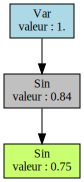

In [ ]:
# Définition d'une variable :
x = Var(1.0)

# Définition d'une fonction quelconque à l'aide des opérations existantes.
# Ici on n'a défini qu'une seule opération, donc on ne peut qu'éventuellement la composer avec elle-même,
# autant de fois qu'on le veut :
f = Sin(Sin(x))

# Ici f est donc un objet de la classe Sin:
print("f :",f)

# Il contient la valeur f(x)=f(1)=sin(sin(1)) mais pas seulement : grâce aux deux champs arg et val contenus dans
# chaque objet Sin, on peut aussi accéder aux valeurs intermédiaires ayant permis de calculer f(x) :
print("f.val =", f.val, " (=sin(sin(1)))")
print("f.arg.val =", f.arg.val, " (=sin(1))")
print("f.arg.arg.val =", f.arg.arg.val, " (=1)")

# affichage du graphe de calcul
show_graph(f)

<br>

Deuxième exemple avec un vecteur en entrée, et non un scalaire.
On voit que tout fonctionne comme attendu, car on a utilisé la fonction `np.sin` qui est vectorisée:

f.val = [0.09127054 0.70568616 0.46043196 0.47754608]
f.arg.val = [0.09139773 0.78339112 0.47848174 0.49785962]
f.arg.arg.val = [0.09152546 0.9001033  0.49892486 0.52112903]
graphe de f:


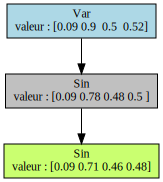

In [ ]:
x = Var(np.random.rand(4))
f = Sin(Sin(x))
print("f.val =", f.val)
print("f.arg.val =", f.arg.val)
print("f.arg.arg.val =", f.arg.arg.val)

print("graphe de f:")
show_graph(f)

## 1. Premier module d'auto-différentiation
On va simplement redéfinir notre module en rajoutant une méthode `.Grad` dans chaque classe.
Cette opération doit implémenter l'application adjointe $\nabla f(x)=Df(x)^*$ de la différentielle $Df(x)$, vérifiant la relation $\langle Df(x).u,v\rangle=\langle u,\nabla f(x).v\rangle$ (pour le produit scalaire euclidien).

_remarque : on pourrait tout à fait écrire également une méthode `.Diff` dans chaque classe pour implémenter l'application différentielle directe._

On écrit également une fonction `Grad` indépendante pour implémenter le gradient d'une fonction scalaire au sens usuel (ou encore simplement la dérivée si la variable est scalaire également), ce qui revient à appliquer la méthode `.Grad` avec $v=1$.

In [ ]:
class Sin:
    def __init__(self,arg):
        self.arg = arg
        self.val = np.sin(arg.val)
    def Grad(self,x,v):
        # on écrit la règle de composition : on a f(x)=sin(g(x)) donc
        # ∇f(x).v = ∇g(x).(cos(g(x))v)
        # g correspond à l'opération self.arg et g(x) à sa valeur :
        g = self.arg
        gx = self.arg.val
        return g.Grad(x, np.cos(gx) * v)

class Var:
    def __init__(self,arg):
        self.val = arg
    def Grad(self,x,v):
        # Soit on dérive x par rapport à x, donc l'application gradient est l'identité,
        # soit on dérive par rapport à une autre variable donc le gradient est nul.
        if x==self:
            return v
        else:
            return 0

def Grad(f, x, v=1.0):
    return f.Grad(x,v)

Exemple : dérivée de $f(x)=\sin(\sin(x))$ en $x=1$:

In [ ]:
x = Var(1.0)
f = Sin(Sin(x))
Gf = Grad(f,x)

print("test pour f(x)=sin(sin(x)) avec x=1:")
print("Grad(f,x) = ", Gf)
print("vérification : cos(sin(1))*cos(1) =", np.cos(np.sin(1.0))*np.cos(1.0))

test pour f(x)=sin(sin(x)) avec x=1:
Grad(f,x) =  0.36003948908962097
vérification : cos(sin(1))*cos(1) = 0.36003948908962097


<br>
Rajoutons quelques opérations pour avoir des exemples plus intéressants :

In [ ]:
class Cos:
    def __init__(self,arg):
        self.arg = arg
        self.val = np.cos(arg.val)
    def Grad(self,x,v):
        # on écrit la règle de composition : on a f(x)=cos(g(x)) donc
        # ∇f(x).v = ∇g(x).(-sin(g(x))v)
        g = self.arg
        gx = self.arg.val
        return g.Grad(x, -np.sin(gx) * v)

class Mult:
    def __init__(self,arg1,arg2):
        self.arg1 = arg1
        self.arg2 = arg2
        self.val = arg1.val * arg2.val
    def Grad(self,x,v):
        # on écrit la règle de composition : on a f(x)=g(x)h(x) donc
        # ∇f(x).v = ∇g(x).(h(x)v)+∇h(x).(g(x)v)
        g, gx = self.arg1, self.arg1.val
        h, hx = self.arg2, self.arg2.val
        return g.Grad(x,hx*v) + h.Grad(x,gx*v)

<br>
Exemple : dérivée de $f(x)=\sin(x\cos(x))$ en $x=2$ :

test pour f(x)=sin(x*cos(x)) avec x=2:
Grad(f,x) =  -1.5043865686656768
vérification : cos(2*cos(2))*(cos(2)-2*sin(2)) = -1.504386568665677
graphe de f:


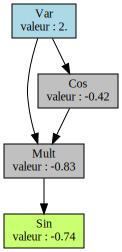

In [ ]:
x = Var(2.0)
f = Sin(Mult(x,Cos(x)))
Gf = Grad(f,x)

print("test pour f(x)=sin(x*cos(x)) avec x=2:")
print("Grad(f,x) = ", Gf)
print("vérification : cos(2*cos(2))*(cos(2)-2*sin(2)) =", np.cos(2*np.cos(2))*(np.cos(2)-2*np.sin(2)))

print("graphe de f:")
show_graph(f)

<br>
Exemple à plusieurs variables:
dérivées en $x$ et $y$ de $f(x,y)=x\sin(y)\cos(xy)$ en $(x,y)=(2,-3.5)$:

test pour f(x)= x sin(y) cos(xy) en (x,y)=(2,-3.5):
Grad(f,x) =  -1.3487628913907883
vérification : sin(-3.5)*(cos(2*(-3.5))-2*(-3.5)*sin(2*(-3.5))) = -1.348762891390788
Grad(f,y) =  -0.49015409669718135
vérification : 2*(cos(-3.5)*cos(2*(-3.5))-2*sin(-3.5)*sin(2*(-3.5))) = -0.49015409669718135
graphe de f:


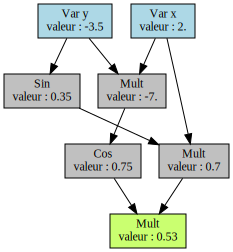

In [ ]:
x = Var(2.0)
y = Var(-3.5)
f = Mult(Mult(x,Sin(y)),Cos(Mult(x,y)))
Gfx = Grad(f,x)
Gfy = Grad(f,y)

print("test pour f(x)= x sin(y) cos(xy) en (x,y)=(2,-3.5):")
print("Grad(f,x) = ", Gfx)
print("vérification : sin(-3.5)*(cos(2*(-3.5))-2*(-3.5)*sin(2*(-3.5))) =", np.sin(-3.5)*(np.cos(2*(-3.5))-2*(-3.5)*np.sin(2*(-3.5))))

print("Grad(f,y) = ", Gfy)
print("vérification : 2*(cos(-3.5)*cos(2*(-3.5))-2*sin(-3.5)*sin(2*(-3.5))) =", 2*(np.cos(-3.5)*np.cos(2*(-3.5))-2*np.sin(-3.5)*np.sin(2*(-3.5))))

print("graphe de f:")
show_graph(f, {'x':x, 'y':y})

## 2. Rédéfinition d'opérateurs

Pour que le module soit un peu plus convivial, on peut redéfinir les opérateurs comme par exemple `*` pour la multiplication. On peut aussi redéfinir la fonction `print` pour nos objets pour afficher uniquement la valeur de la fonction. Ceci a pour effet de rendre le module presque "transparent" pour l'utilisateur.

Ceci nécessite de redéfinir toutes les classes en les faisant toutes dériver d'une classe `Operation`, où on définit ces opérateurs.

On en profite pour rajouter l'opération d'addition et son opérateur `+`.

In [ ]:
class Operation:
    def __mul__(self, other):
        return Mult(self,other)
    def __add__(self, other):
        return Add(self,other)
    def __repr__(self):
        return str(self.val)

class Sin(Operation):
    def __init__(self,arg):
        self.arg = arg
        self.val = np.sin(arg.val)
    def Grad(self,x,v):
        g, gx = self.arg, self.arg.val
        return g.Grad(x, np.cos(gx) * v)

class Cos(Operation):
    def __init__(self,arg):
        self.arg = arg
        self.val = np.cos(arg.val)
    def Grad(self,x,v):
        g, gx = self.arg, self.arg.val
        return g.Grad(x, -np.sin(gx) * v)

class Mult(Operation):
    def __init__(self,arg1,arg2):
        self.arg1 = arg1
        self.arg2 = arg2
        self.val = arg1.val * arg2.val
    def Grad(self,x,v):
        g, gx = self.arg1, self.arg1.val
        h, hx = self.arg2, self.arg2.val
        return g.Grad(x,hx*v) + h.Grad(x,gx*v)

class Add(Operation):
    def __init__(self,arg1,arg2):
        self.arg1 = arg1
        self.arg2 = arg2
        self.val = arg1.val + arg2.val
    def Grad(self,x,v):
        g, h = self.arg1, self.arg2
        return g.Grad(x,v) + h.Grad(x,v)

class Var(Operation):
    def __init__(self,arg):
        self.val = arg
    def Grad(self,x,v):
        if x==self:
            return v
        else:
            return 0

def Grad(f, x, v=1.0):
    return f.Grad(x,v)

<br>
On peut maintenant plus directement écrire les formules et afficher les valeurs obtenues :

In [ ]:
x = Var(2.0)
y = Var(-3.5)
f = x*Sin(y)*Cos(x*y)

print(f)
print(Grad(f,x))
print(Grad(f,y))

0.5289125322820502
-1.3487628913907883
-0.49015409669718135


## 3. Classes avec méthodes `.Grad` et  `.Backward`
Lorsqu'on doit calculer les gradients par rapport a plusieurs variables, plutôt que d'appeler plusieurs fois la fonction `Grad`, on peut implémenter une méthode `.Backward` dans chaque classe. Cette méthode fonctionne un peu différemment ; elle ne prend pas de variable comme argument et ne renvoie aucune valeur. Elle remonte le graphe de calcul une seule fois jusqu'à aboutir aux feuilles (objet de classe `Var`) pour lesquelles elle incrémente une variable qu'on note `.grad`.

On rajoute aussi quelques opérations : `Minus`, `Sum` et `Item`

In [ ]:
class Operation:
    def __mul__(self, other):
        return Mult(self,other)
    def __add__(self, other):
        return Add(self,other)
    def __getitem__(self, ind):
        return Item(self, ind)
    def __neg__(self):
        return Minus(self)
    def __sub__(self, other):
        return self+(-other)
    def __repr__(self):
        return str(self.val)

class Sin(Operation):
    def __init__(self,arg):
        self.arg = arg
        self.val = np.sin(arg.val)
    def Grad(self,x,v):
        g, gx = self.arg, self.arg.val
        return g.Grad(x, np.cos(gx) * v)
    def Backward(self,v):
        g, gx = self.arg, self.arg.val
        g.Backward(np.cos(gx) * v)

class Cos(Operation):
    def __init__(self,arg):
        self.arg = arg
        self.val = np.cos(arg.val)
    def Grad(self,x,v):
        g, gx = self.arg, self.arg.val
        return g.Grad(x, -np.sin(gx) * v)
    def Backward(self,v):
        g, gx = self.arg, self.arg.val
        g.Backward(-np.sin(gx) * v)

class Mult(Operation):
    def __init__(self,arg1,arg2):
        self.arg1 = arg1
        self.arg2 = arg2
        self.val = arg1.val * arg2.val
    def Grad(self,x,v):
        g, gx = self.arg1, self.arg1.val
        h, hx = self.arg2, self.arg2.val
        return g.Grad(x,hx*v) + h.Grad(x,gx*v)
    def Backward(self,v):
        g, gx = self.arg1, self.arg1.val
        h, hx = self.arg2, self.arg2.val
        g.Backward(hx*v)
        h.Backward(gx*v)

class Add(Operation):
    def __init__(self,arg1,arg2):
        self.arg1 = arg1
        self.arg2 = arg2
        self.val = arg1.val + arg2.val
    def Grad(self,x,v):
        g, h = self.arg1, self.arg2
        return g.Grad(x,v) + h.Grad(x,v)
    def Backward(self,v):
        g, h = self.arg1, self.arg2
        g.Backward(v)
        h.Backward(v)

class Minus(Operation):
    def __init__(self,arg):
        self.arg = arg
        self.val = -arg.val
    def Grad(self,x,v):
        g = self.arg
        return g.Grad(x,-v)
    def Backward(self,v):
        g = self.arg
        g.Backward(-v)

class Item(Operation):
    # Item est l'opération i-ème coordonnée x -> x_i
    def __init__(self, arg, ind):
        self.arg = arg
        self.val = arg.val[ind]
        self.ind = ind
    def Grad(self,x,v):
        g, gx, i = self.arg, self.arg.val, self.ind
        # On a f(x) = g(x)_i = <g(x),ei> donc
        # ∇f(x).v = ∇g(x).u avec u=[0,...,0,v,0,...,0]
        u = np.zeros(gx.shape)
        u[i] = v
        return g.Grad(x,u)
    def Backward(self,v):
        g, gx, i = self.arg, self.arg.val, self.ind
        u = np.zeros(gx.shape)
        u[i] = v
        g.Backward(u)

class Sum(Operation):
    # Opération x -> sum_i x_i
    def __init__(self,arg):
        self.arg = arg
        self.val = np.sum(arg.val)
    def Grad(self,x,v):
        g, gx = self.arg, self.arg.val
        # On a f(x) = g(x)_i = sum_i g(x)_i donc
        # ∇f(x).v = ∇g(x).u avec u=[v,...,v]
        u = np.ones(gx.shape)
        return g.Grad(x,u*v)
    def Backward(self,v):
        g, gx = self.arg, self.arg.val
        u = np.ones(gx.shape)
        g.Backward(u*v)

class Var(Operation):
    def __init__(self,arg):
        self.val = arg
        self.grad = 0
    def Grad(self,x,v):
        if x==self:
            return v
        else:
            return 0
    def Backward(self,v):
        self.grad += v

def Grad(f, x, v=1.0):
    return f.Grad(x,v)

def Backward(f, v=1.0):
    f.Backward(v)

In [ ]:
x = Var(np.random.rand(4))
y = Var(np.random.rand(4))
f = Sum(x*y)*Cos(y[2])

print("f = ",f)

print("gradients via la méthode .Grad:")
print("Grad(f,x) = ", Grad(f,x))
print("Grad(f,y) = ", Grad(f,y))

print("gradients via la méthode .Backward:")
Backward(f)
print("x.grad = ", x.grad)
print("y.grad = ", y.grad)

f =  0.7428096485674753
gradients via la méthode .Grad:
Grad(f,x) =  [0.19814442 0.60788368 0.55281691 0.19430467]
Grad(f,y) =  [ 0.49886593  0.45838719 -0.5511863   0.31967475]
gradients via la méthode .Backward:
x.grad =  [0.19814442 0.60788368 0.55281691 0.19430467]
y.grad =  [ 0.49886593  0.45838719 -0.5511863   0.31967475]


A la différence de `Grad`, la méthode `Backward` est piégeuse : si on appelle plusieurs fois `Backward` pour la même fonction, ou pour toute autre fonction qui est définie à partir des mêmes variables, les gradients sont accumulés :

In [ ]:
x = Var(1.0)
y = Var(2.0)
f = Sin(x*y)*Cos(y)
g = x+y

print("Grad(f,x)=", Grad(f,x))
Backward(f)
print("x.grad=",x.grad)

Backward(f)
print("x.grad=",x.grad)

print("Grad(g,x)=", Grad(g,x))
Backward(g)
print("x.grad=",x.grad)

Grad(f,x)= 0.3463563791363881
x.grad= 0.3463563791363881
x.grad= 0.6927127582727762
Grad(g,x)= 1.0
x.grad= 1.6927127582727763


## 4. Dérivations aux ordres supérieurs.
Dernière étape : on construit un système clos afin de pouvoir dériver à n'importe quel ordre. Ceci implique que les opérations `.Grad` ou `.Backward` vont devoir retourner non pas des valeurs directement mais des objets de la classe Operation. Il faut donc ajouter quelques opérations (adjointes des opérations `Sum` et `Item`) ainsi qu'une classe pour les fonctions constantes `Cst`. On ajoute également l'opération `Exp`.

In [ ]:
class Operation:
    def __mul__(self, other):
        return Mult(self,other)
    def __add__(self, other):
        # on ajoute ici des règles de simplification :
        # 0+f=f et f+0=f
        if isinstance(self,Cst) and self.val==0.0:
            return other
        elif isinstance(other,Cst) and other.val==0.0:
            return self
        else:
            return Add(self,other)
    def __getitem__(self, ind):
        return Item(self, ind)
    def __neg__(self):
        return Minus(self)
    def __sub__(self, other):
        return self+(-other)
    def __repr__(self):
        return str(self.val)
    def __pow__(self,order):
        if order==2:
            return self*self
        else:
            raise ValueError("not implemented")

class Sin(Operation):
    def __init__(self,arg):
        self.arg = arg
        self.val = np.sin(arg.val)
    def Grad(self,x,v):
        # Ici v est également un objet de classe Operation et non pas juste une valeur,
        # et on retourne également un objet de la classe Operation
        g = self.arg
        return g.Grad(x, Cos(g) * v)
    def Backward(self,v):
        g = self.arg
        g.Backward(Cos(g) * v)

class Cos(Operation):
    def __init__(self,arg):
        self.arg = arg
        self.val = np.cos(arg.val)
    def Grad(self,x,v):
        g = self.arg
        return g.Grad(x, -Sin(g) * v)
    def Backward(self,v):
        g = self.arg
        g.Backward(-Sin(g) * v)

class Exp(Operation):
    def __init__(self,arg):
        self.arg = arg
        self.val = np.exp(arg.val)
    def Grad(self,x,v):
        g = self.arg
        return g.Grad(x, Exp(g) * v)
    def Backward(self,v):
        g = self.arg
        g.Backward(Exp(g) * v)

class Mult(Operation):
    def __init__(self,arg1,arg2):
        self.arg1 = arg1
        self.arg2 = arg2
        self.val = arg1.val * arg2.val
    def Grad(self,x,v):
        g, h = self.arg1, self.arg2
        return g.Grad(x,h*v) + h.Grad(x,g*v)
    def Backward(self,v):
        g, h = self.arg1, self.arg2
        g.Backward(h*v)
        h.Backward(g*v)

class Add(Operation):
    def __init__(self,arg1,arg2):
        self.arg1 = arg1
        self.arg2 = arg2
        self.val = arg1.val + arg2.val
    def Grad(self,x,v):
        g, h = self.arg1, self.arg2
        return g.Grad(x,v) + h.Grad(x,v)
    def Backward(self,v):
        g, h = self.arg1, self.arg2
        g.Backward(v)
        h.Backward(v)

class Minus(Operation):
    def __init__(self,arg):
        self.arg = arg
        self.val = -arg.val
    def Grad(self,x,v):
        g = self.arg
        return g.Grad(x,-v)
    def Backward(self,v):
        g = self.arg
        g.Backward(-v)

class Item(Operation):
    def __init__(self, arg, ind):
        self.arg = arg
        self.val = arg.val[ind]
        self.ind = ind
        self.dim = len(arg.val)
    def Grad(self,x,v):
        g, dim, i = self.arg, self.dim, self.ind
        return g.Grad(x,Item_Adjoint(v,dim,i))
    def Backward(self,v):
        g, dim, i = self.arg, self.dim, self.ind
        g.Backward(Item_Adjoint(v,dim,i))

class Item_Adjoint(Operation):
    def __init__(self, arg, dim, ind):
        self.arg = arg
        u = np.zeros(dim)
        u[ind] = arg.val
        self.val = u
        self.dim = dim
        self.ind = ind
    def Grad(self,x,v):
        g, dim, i = self.arg, self.dim, self.ind
        return g.Grad(x,u[i])
    def Backward(self,v):
        g, dim, i = self.arg, self.dim, self.ind
        g.Backward(v[i])

class Sum(Operation):
    def __init__(self,arg):
        self.arg = arg
        self.val = np.sum(arg.val)
        self.dim = len(arg.val)
    def Grad(self,x,v):
        g, dim = self.arg, self.dim
        return g.Grad(x,Sum_Adjoint(v,dim))
    def Backward(self,v):
        g, dim = self.arg, self.dim
        g.Backward(Sum_Adjoint(v,dim))

class Sum_Adjoint(Operation):
    def __init__(self,arg,dim):
        self.arg = arg
        self.val = np.full(dim,arg.val)
        self.dim = dim
    def Grad(self,x,v):
        g = self.arg
        return g.Grad(x,Sum(v))
    def Backward(self,v):
        g = self.arg
        g.Backward(Sum(v))

class Cst(Operation):
    # implémente une fonction constante
    def __init__(self,val):
        self.val = val
    def Grad(self,x,v):
        return Cst(0.)
    def Backward(self,v):
        pass

class Var(Operation):
    def __init__(self,arg):
        self.val = arg
        self.grad = Cst(0.0)
    def Grad(self,x,v):
        if x==self:
            return v
        else:
            return Cst(0.0)
    def Backward(self,v):
        self.grad = self.grad + v

def Grad(f, x, v=Cst(1.0)):
    return f.Grad(x,v)

def Backward(f, v=Cst(1.0)):
    f.Backward(v)

<br>
Exemple avec la fonction gaussienne $\displaystyle f(p,x,y)=e^{-p*\|x-y\|^2}$ pour $p\in\mathbb{R}$ et $x,y\in\mathbb{R}^3$.
On calcule $f$, $\nabla_xf$, $\nabla_pf$, $\nabla_x(\nabla_pf)$ et $\nabla_x(\nabla_x(\nabla_pf)[1])$:

In [ ]:
x = Var(np.random.rand(3))
y = Var(np.random.rand(3))
p = Var(np.random.rand(1))
f = Exp(-p*Sum((x-y)**2))

print("f = ", f)
print("Grad(f,x) = ", Grad(f,x))
print("Grad(f,p) = ", Grad(f,p))
print("Grad(Grad(f,p),x) = ", Grad(Grad(f,p),x))
print("Grad(Grad(Grad(f,p),x)[1],x) = ", Grad(Grad(Grad(f,p),x)[1],x))

f =  [0.99566043]
Grad(f,x) =  [ 0.04678515 -0.04157517  0.02616842]
Grad(f,p) =  [-0.0162262]
Grad(Grad(f,p),x) =  [ 0.17455398 -0.1551157   0.09763358]
Grad(Grad(Grad(f,p),x)[1],x) =  [-0.01460932 -1.96967813 -0.00817146]


On peut maintenant afficher tous les graphes de calcul des gradients:

graphe de f:


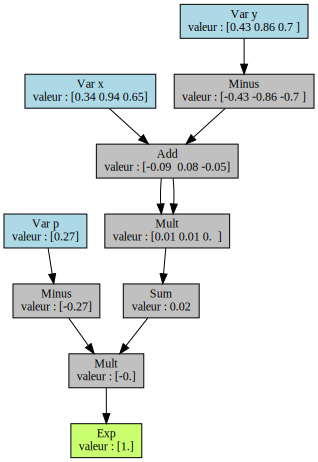

In [ ]:
print("graphe de f:")
show_graph(f,{'x':x,'y':y,'p':p})

graphe de Grad(f,x):


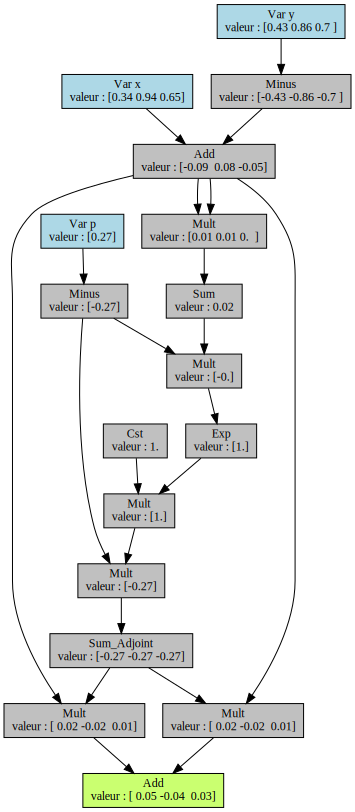

In [ ]:
print("graphe de Grad(f,x):")
show_graph(Grad(f,x),{'x':x,'y':y,'p':p})

graphe de Grad(f,p):


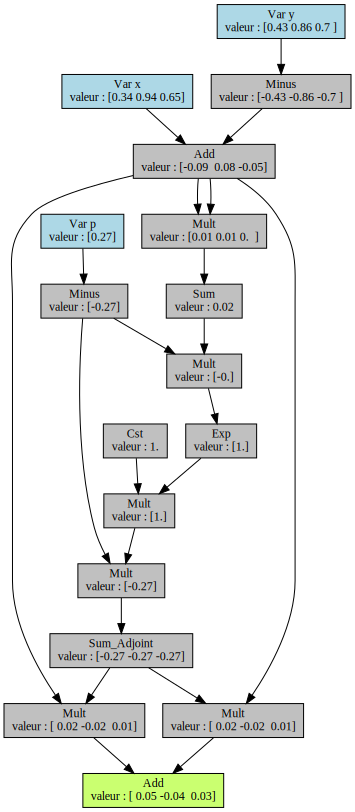

In [ ]:
print("graphe de Grad(f,p):")
show_graph(Grad(f,x),{'x':x,'y':y,'p':p})

graphe de Grad(Grad(f,p),x):


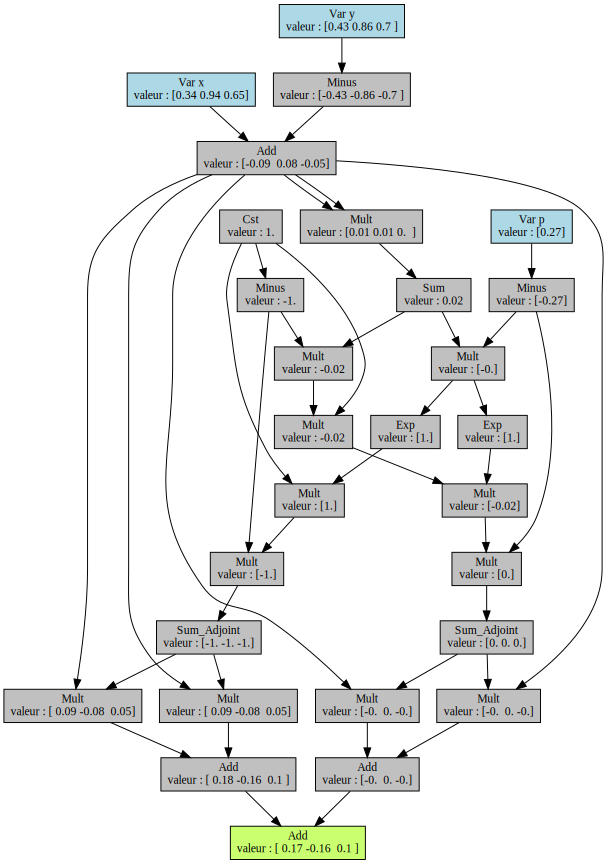

In [ ]:
print("graphe de Grad(Grad(f,p),x):")
show_graph(Grad(Grad(f,p),x),{'x':x,'y':y,'p':p})

graphe de Grad(Grad(Grad(f,p),x)[1],x):


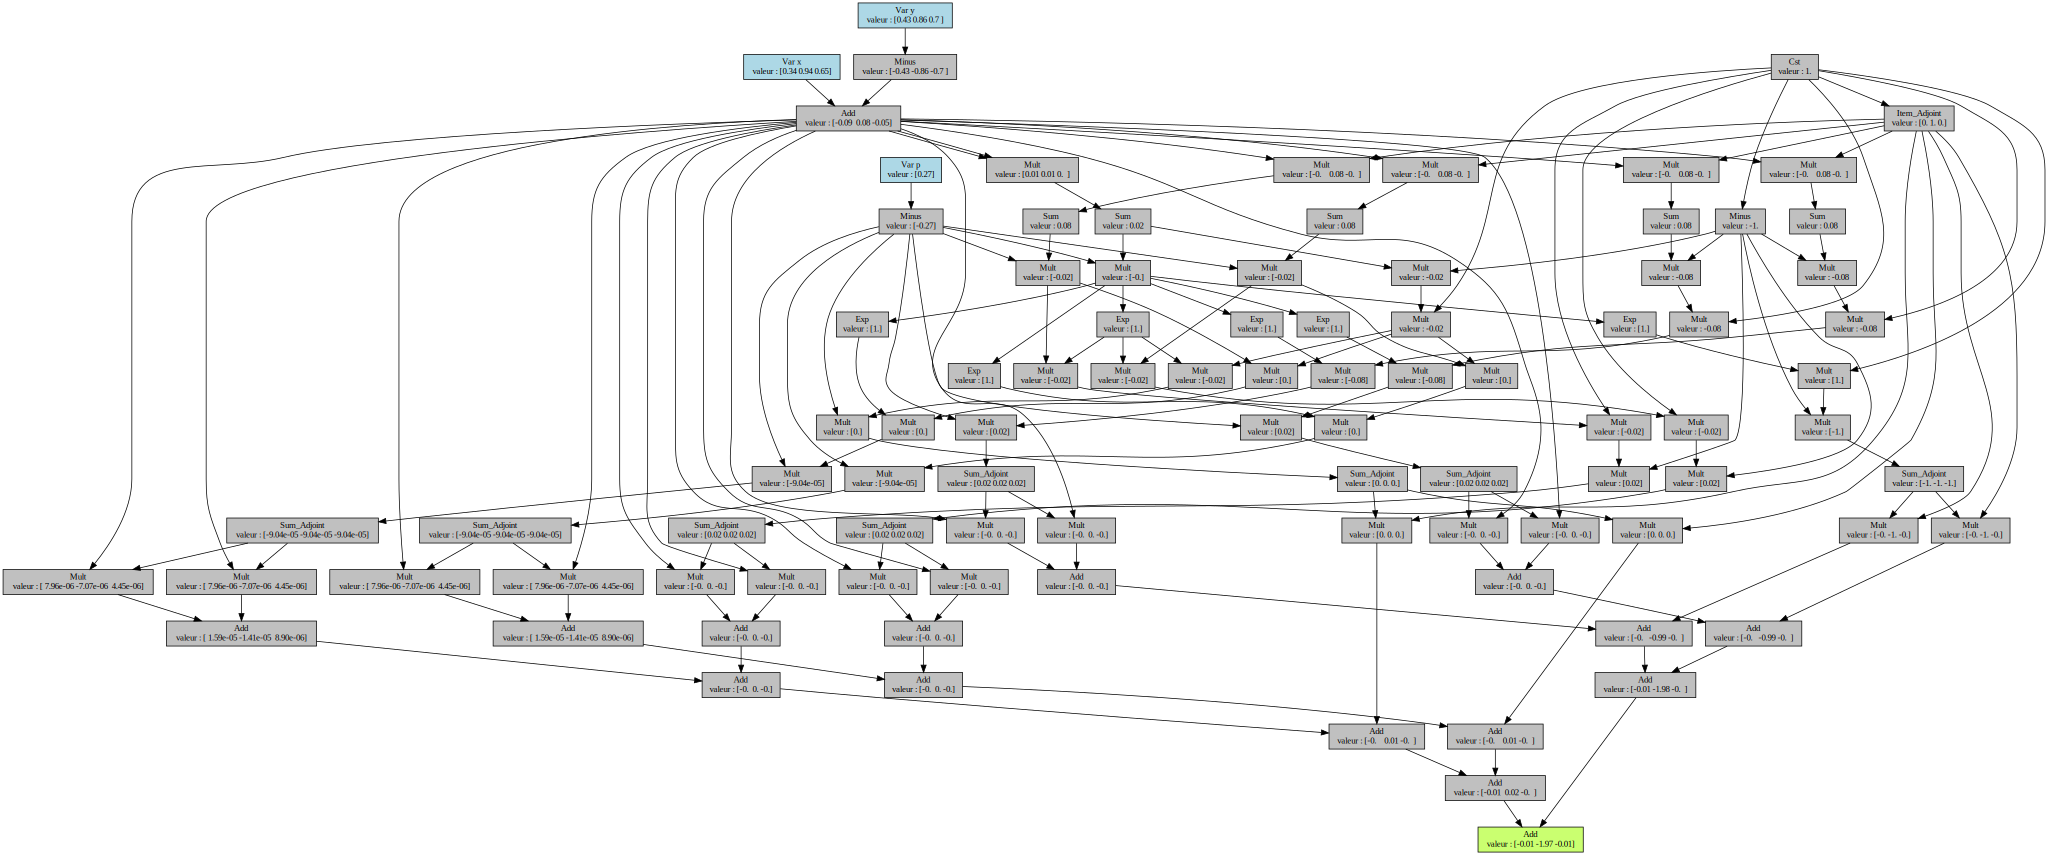

In [ ]:
print("graphe de Grad(Grad(Grad(f,p),x)[1],x):")
show_graph(Grad(Grad(Grad(f,p),x)[1],x),{'x':x,'y':y,'p':p})

On remarque que le graphe du gradient à l'ordre 3 est extrêmement complexe. Il le serait encore plus si on n'avait pas déjà ajouté les règles de simplification $0+f=f$ et $f+0=f$. En ajoutant d'autres règles ($0*f=0$, $1*f=f$, factorisations, etc.), on pourrait fortement simplifier le graphe, et donc accélérer l'exécution.